Caricamento dei dati...

Valori mancanti nel dataset:
datetime         0
ts_get         781
value            0
areaAnalisi      0
id             781
hum            781
pres           781
rain_1h        781
wind_speed     781
wind_deg       781
clouds_all     781
max_temp       781
min_temp       781
ave_temp       781
cod_weather    781
dtype: int64
Righe dopo la rimozione dei valori mancanti: 5835

Addestramento del sistema...


C:\Users\pevel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Caratteristiche dei cluster:

Cluster Profiles:
                value
                 mean
cluster              
0        24277.673956
1        30526.844763

Cluster critico: 1

Analisi dei dati attuali...

Addestramento del sistema K-means...

Caratteristiche dei cluster:

Cluster Profiles:
                value
                 mean
cluster              
0        26979.053384
1        28623.571429

Cluster critico: 1

Analisi del dataset completo...


C:\Users\pevel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Creazione visualizzazioni...


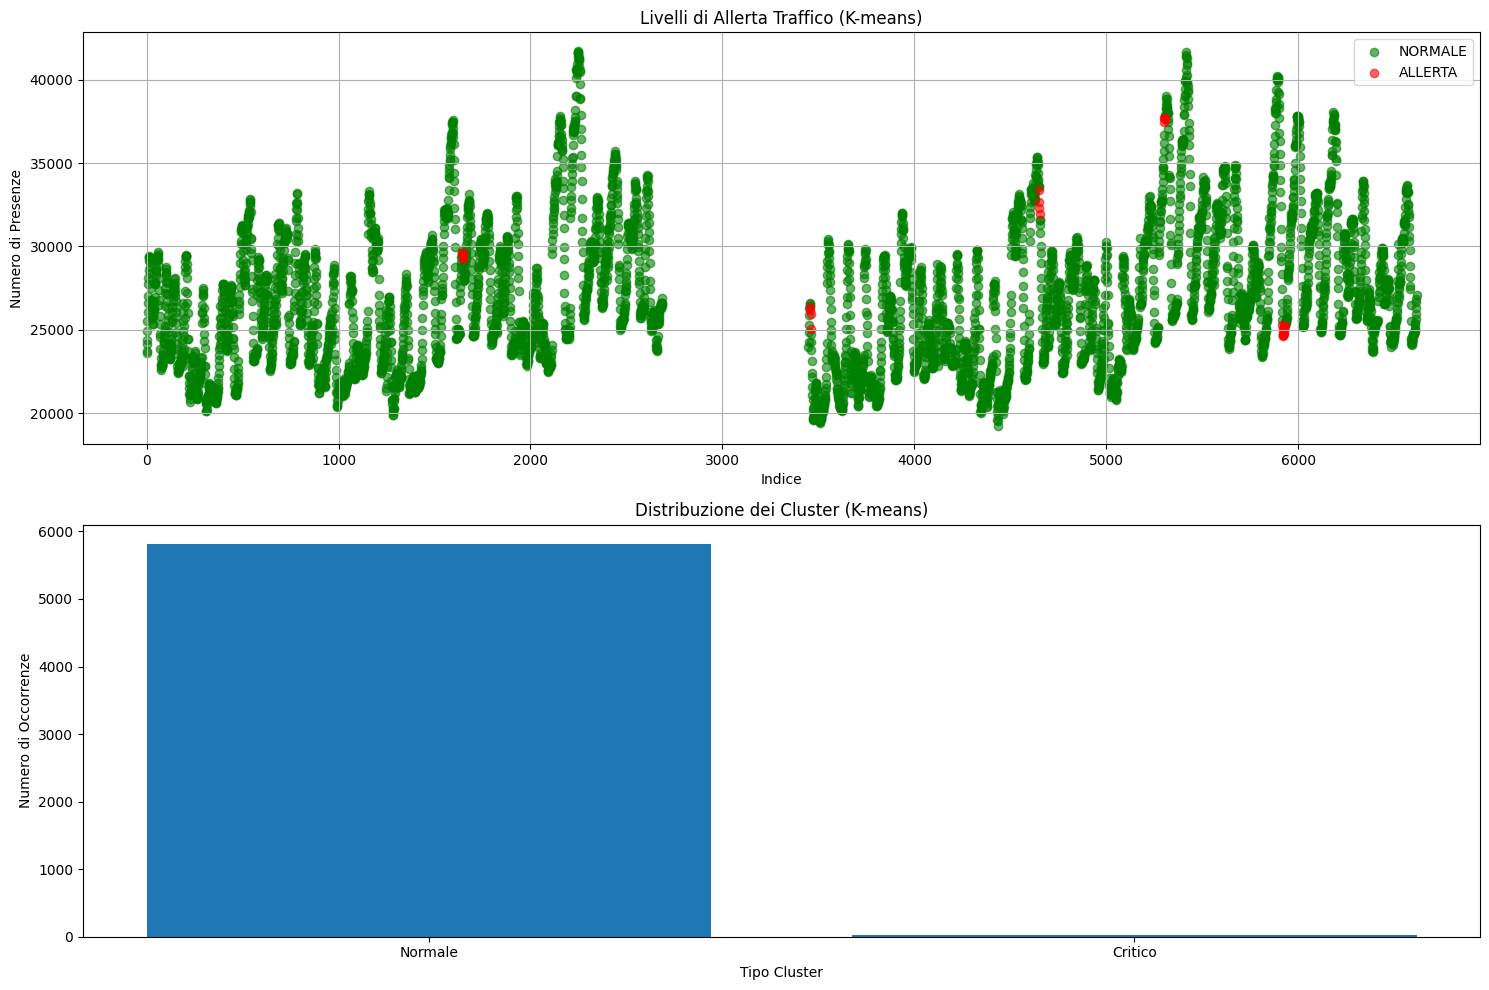


Riepilogo Allerte:
alarm_level
NORMALE    5807
ALLERTA      28
Name: count, dtype: int64

Dettaglio situazioni di allerta:
      index            value alarm_level   
1645   1645  29580 (ALLERTA)     ALLERTA  \
1646   1646  29621 (ALLERTA)     ALLERTA   
1647   1647  29343 (ALLERTA)     ALLERTA   
1648   1648  29266 (ALLERTA)     ALLERTA   
2693   3457  26338 (ALLERTA)     ALLERTA   
2694   3458  26208 (ALLERTA)     ALLERTA   
2695   3459  25928 (ALLERTA)     ALLERTA   
2696   3460  25066 (ALLERTA)     ALLERTA   
3885   4649  33394 (ALLERTA)     ALLERTA   
3886   4650  32645 (ALLERTA)     ALLERTA   
3887   4651  32312 (ALLERTA)     ALLERTA   
3888   4652  31942 (ALLERTA)     ALLERTA   
4525   5301  37486 (ALLERTA)     ALLERTA   
4526   5302  37734 (ALLERTA)     ALLERTA   
4527   5303  37622 (ALLERTA)     ALLERTA   
4528   5304  37735 (ALLERTA)     ALLERTA   
5141   5917  25261 (ALLERTA)     ALLERTA   
5142   5918  25067 (ALLERTA)     ALLERTA   
5143   5919  24811 (ALLERTA)     ALLERTA

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

class TrafficBinaryClusterSystem:
    def __init__(self):
        self.scaler = StandardScaler()
        self.kmeans = None
        self.cluster_profiles = None
        
    def fit(self, df):
        """
        Addestra il sistema di clustering sui dati storici con due cluster
        """
        # Prepara le feature
        df = self._prepare_features(df)
        
        # Standardizzazione
        X_scaled = self.scaler.fit_transform(df)
        
        # 1. Clustering binario
        self.kmeans = KMeans(n_clusters=2, random_state=42)
        clusters = self.kmeans.fit_predict(X_scaled)
        
        # 2. Analisi dei cluster per identificare quello critico
        self.cluster_profiles = self._analyze_clusters(df, clusters)
        
        return self
    
    def _prepare_features(self, df):
        """
        Prepara le feature per l'analisi
        """
        features = [
            'value',
            'rain_1h',
            'wind_speed',
        ]
        
        return df[features]

    def _analyze_clusters(self, df, clusters):
        df_with_clusters = df.copy()
        df_with_clusters['cluster'] = clusters
        
        profiles = df_with_clusters.groupby('cluster').agg({
            'value': ['mean'],
        })
        
        # Il cluster critico è quello con il valore medio più alto
        critical_cluster = profiles[('value', 'mean')].idxmax()
        
        return {
            'profiles': profiles,
            'critical_cluster': critical_cluster
        }
    
    def check_cluster(self, current_data):
        """
        Verifica il cluster e determina se è in stato di allerta
        """
        # Prepara i dati correnti
        current_df = self._prepare_features(current_data)
        
        # Standardizzazione
        current_scaled = self.scaler.transform(current_df)
        
        # Determina il cluster
        cluster = self.kmeans.predict(current_scaled)[0]
        is_critical_cluster = (cluster == self.cluster_profiles['critical_cluster'])
        
        # Determina il livello di allerta
        if is_critical_cluster:
            alarm_level = 'ALLERTA'
            reasons = ['Condizioni di traffico critiche rilevate']
        else:
            alarm_level = 'NORMALE'
            reasons = ['Condizioni di traffico nella norma']
        
        return {
            'alarm_level': alarm_level,
            'reasons': reasons,
            'details': {
                'current_value': current_df['value'].iloc[0],
                'rain_1h': current_df['rain_1h'].iloc[0],
                'wind_speed': current_df['wind_speed'].iloc[0],
                'cluster': cluster,
                'is_critical_cluster': is_critical_cluster
            }
        }

# Script principale
print("Caricamento dei dati...")
df = pd.read_csv('dataset_output/df1.csv')

# Rimozione valori mancanti
print("\nValori mancanti nel dataset:")
print(df.isnull().sum())
df = df.dropna()
print("Righe dopo la rimozione dei valori mancanti:", len(df))

# Dividiamo i dati in training (80%) e test (20%)
train_size = int(len(df) * 0.8)
historical_data = df[:train_size].copy()
current_data = df[train_size:].copy()

print("\nAddestramento del sistema...")
cluster_system = TrafficBinaryClusterSystem()
cluster_system.fit(historical_data)

print("\nCaratteristiche dei cluster:")
print("\nCluster Profiles:")
print(cluster_system.cluster_profiles['profiles'])
print(f"\nCluster critico: {cluster_system.cluster_profiles['critical_cluster']}")

print("\nAnalisi dei dati attuali...")
results = []
for idx, row in current_data.iterrows():
    current_point = pd.DataFrame([row])
    result = cluster_system.check_cluster(current_point)
    results.append({
        'index': idx,
        'value': row['value'],
        'rain_1h': row['rain_1h'],
        'wind_speed': row['wind_speed'],
        'alarm_level': result['alarm_level'],
        'reasons': ' | '.join(result['reasons']),
        'cluster': result['details']['cluster']
    })

# Addestramento del sistema K-means su tutto il dataset
print("\nAddestramento del sistema K-means...")
quantum_system = TrafficBinaryClusterSystem()
quantum_system.fit(df)

print("\nCaratteristiche dei cluster:")
print("\nCluster Profiles:")
print(quantum_system.cluster_profiles['profiles'])
print(f"\nCluster critico: {quantum_system.cluster_profiles['critical_cluster']}")

print("\nAnalisi del dataset completo...")
results = []
for idx, row in df.iterrows():
    current_point = pd.DataFrame([row])
    result = quantum_system.check_cluster(current_point)
    results.append({
        'index': idx,
        'value': f"{row['value']} {'(ALLERTA)' if result['alarm_level'] == 'ALLERTA' else '(NORMALE)'}",
        'rain_1h': f"{row['rain_1h']} {'(ALLERTA)' if result['alarm_level'] == 'ALLERTA' else '(NORMALE)'}",
        'wind_speed': f"{row['wind_speed']} {'(ALLERTA)' if result['alarm_level'] == 'ALLERTA' else '(NORMALE)'}",
        'alarm_level': result['alarm_level'],
        'reasons': ' | '.join(result['reasons']),
        'cluster': result['details']['cluster']
    })

# Creazione di un DataFrame con i risultati
results_df = pd.DataFrame(results)

print("\nCreazione visualizzazioni...")
plt.figure(figsize=(15, 10))

# Plot 1: Trend del traffico con livelli di allerta
plt.subplot(2, 1, 1)
colors = {'NORMALE': 'green', 'ALLERTA': 'red'}
for level in colors:
    mask = results_df['alarm_level'] == level
    values = results_df[mask]['value'].apply(lambda x: float(x.split()[0]))
    plt.scatter(results_df[mask]['index'], 
               values,
               c=colors[level],
               label=level,
               alpha=0.6)

plt.title('Livelli di Allerta Traffico (K-means)')  # Modificato a K-means
plt.xlabel('Indice')
plt.ylabel('Numero di Presenze')
plt.legend()
plt.grid(True)

# Plot 2: Distribuzione dei cluster
plt.subplot(2, 1, 2)
cluster_counts = results_df['cluster'].value_counts()
plt.bar(['Normale' if i != quantum_system.cluster_profiles['critical_cluster'] else 'Critico' 
         for i in cluster_counts.index], 
        cluster_counts.values)
plt.title('Distribuzione dei Cluster (K-means)')  # Modificato a K-means
plt.xlabel('Tipo Cluster')
plt.ylabel('Numero di Occorrenze')

plt.tight_layout()
plt.show()

print("\nRiepilogo Allerte:")
print(results_df['alarm_level'].value_counts())

print("\nDettaglio situazioni di allerta:")
alert_situations = results_df[results_df['alarm_level'] == 'ALLERTA']
if not alert_situations.empty:
    print(alert_situations[['index', 'value', 'alarm_level', 'reasons']])
else:
    print("Nessuna situazione di allerta rilevata")

# Salviamo i risultati
results_df.to_csv('risultati_binary_cluster.csv', index=False)
print("\nRisultati salvati in 'risultati_binary_cluster.csv'")
